In [294]:
import itertools

import numpy as np
import scipy.linalg
import pandas as pd
import pyemma
from pyemma import msm

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import pyemma.plots as mplt

%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [289]:
class HummerCG(object):
    
    def __init__(self,msm,grps):
        """
        coarse-grains micro msm using groups 
        """
        
        pi_micro = msm.pi
        T = msm.P
        
        ## prep aggregation matrix
        n_cg = len(grps)
        n_micro = len(np.concatenate(grps))
        assert T.shape == (n_micro,n_micro) 
        assert len(pi_micro)== n_micro
        A = np.zeros((n_micro,n_cg))
        for i,grp in enumerate(grps):
            A[np.array(grp),i] = 1
        
        pi_cg = np.dot(pi_micro,A)
        #print(A)
        assert np.abs(pi_micro.sum() - pi_cg.sum())< 1.e-9
        
        ## calc cg matrix (eq. 25b)
        P1_micro = np.dot(pi_micro.reshape((n_micro,1)),np.ones((1,n_micro)))
        D_micro = np.diag(pi_micro)
        P1_cg = np.dot(pi_cg.reshape((n_cg,1)),np.ones((1,n_cg)))
        D_cg = np.diag(pi_cg)
        
        aux1 = np.linalg.inv(np.eye(n_micro) + P1_micro - T)
        aux2a = np.dot(np.transpose(A), aux1)
        aux2b = np.dot(D_micro,A)
        aux3 = np.linalg.inv(np.dot(aux2a,aux2b))
        R = np.eye(n_cg) + P1_cg - np.dot(D_cg,aux3)
        
        self.n_cg = n_cg
        self.grps=grps
        self.pi_cg = pi_cg
        self.T_cg = R
        self.aggregation_matrix = A
        self.msm_micro = msm
        self.pi_micro = msm.pi
        self.T = msm.P
        
    def plot_timescales(self,i, tau=1):
        """
        plots cg timescales and micro timescales
        """
        from msmtools.analysis import eigenvalues as anaeig

        
        ts_micro = self.msm_micro.timescales(i)
        R = self.T_cg

        lambdas_cg = anaeig(R,k=i)
        if np.all(lambdas_cg.imag == 0):
            lambdas_cg = lambdas_cg.real
        #print(lambdas_cg)
        
        ind_perron = np.isclose(np.abs(lambdas_cg), 1.0, rtol=0.0, atol=1e-14)
        assert sum(ind_perron) <= 1
        ts = np.zeros(len(lambdas_cg))

        tau_cg = -1/np.log(np.abs(lambdas_cg))
        plt.plot(ts_micro,'--x',label='micro')
        plt.plot(tau_cg[1:],'-o',label='cg')
        plt.legend()
        plt.xlabel('index')
        plt.ylabel('implied timescales')
        plt.show()
        
    def cg_relaxation_from_state_to_state(self,i_cg,j_cg,nmax=50):
        
        def _relaxation(T,p0,a,nmax):
            """relaxes p0 using T, and returns expectation of observable a"""
            p = p0
            rel = []
            occ = []
            for time in range(nmax):
                rel.append(np.dot(p,a))
                occ.append(p)
                p = np.dot(T,p)
            return np.array(range(nmax)),np.array(rel),np.array(occ)
        
        p0_cg = np.zeros_like(self.pi_cg)
        p0_cg[i_cg]=1
        #print(p0_cg)
        #print(self.T_cg)
        ind_final_cg = np.zeros_like(self.pi_cg)
        ind_final_cg[j_cg] = 1
        #print("ind_final_cg", ind_final_cg)
        time_cg,rel_cg,occ_cg = _relaxation(self.T_cg,p0_cg,a=ind_final_cg,nmax=nmax)
        
        # initial prob in micro, according to local equilibrium in cg state=0
        A_cg = self.aggregation_matrix
        pi0_micro = A_cg[:,i_cg]*self.pi_micro
        pi0_micro = pi0_micro/pi0_micro.sum()
        ind_final_micro = A_cg[:,j_cg]
        time_micro,rel_micro,occ_micro = _relaxation(self.T,pi0_micro,a=ind_final_micro,nmax=nmax)

        plt.plot(time_micro,rel_micro,'x',label='micro')
        plt.plot(time_cg,rel_cg,'-o',label='macro')
        plt.xlabel('steps')
        plt.ylabel('probabilty(%d)'%j_cg)
        plt.title("relaxation from %d to %d" %(i_cg,j_cg))
        plt.legend()
        plt.show()
        
        return time_cg,rel_cg,occ_cg 
        
    def compare_timescales(self):
        import msmtools
        n_cg = self.n_cg
        grp = self.grps
        times=[]
        for i,j in itertools.product(range(n_cg),range(n_cg)):
        #print i,j
            if not i==j:
                ##### the mm.mfpt has swapped indiced!!! WARNING
                t_micro = self.msm_micro.mfpt(A=grp[j],B=grp[i]) 
                t_micro2 = msmtools.analysis.mfpt(self.T,grp[i],grp[j])
                t_cg = msmtools.analysis.mfpt(self.T_cg,i,j)
                times.append([i,j,t_micro2,t_cg])
        times = np.array(times)
        alltimes= 0.1*np.min(times[:,2:4]), 10*np.max(times[:,2:4]), 
        
        plt.plot(times[:,2],times[:,3],'o',linewidth=0)
        plt.plot(list(alltimes),list(alltimes),'--')
        plt.loglog()
        plt.title("MFPT between CG states")
        plt.xlabel('microscopic MFPT')
        plt.ylabel('CG MFPT')
        plt.show()
        
        return pd.DataFrame(times,columns=['from','to','MFPT micro','MFPT macro'])

### Example from Hummer's paper

In [290]:
## define model transition matrix for testing
def Kmod(k,h):
    S=np.array([[0,k,0,0],[k,0,h,0],[0,h,0,k],[0,0,k,0]])
    return S - np.diag(S.sum(axis=1))
T_micro = scipy.linalg.expm(Kmod(k=1,h=5)*0.1)

## define the two cg choices in the paper example
grps1 = [np.array([0,1]),np.array([2,3])]
grps2 = [np.array([0]),np.array([1,2]),np.array([3])]


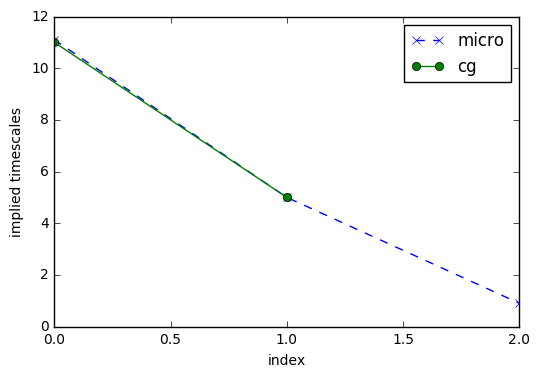

In [291]:
## define the microscopic model and cg it
msm_micro = pyemma.msm.markov_model(T_micro)
cg = HummerCG(msm_micro,grps2)
cg.plot_timescales(4)

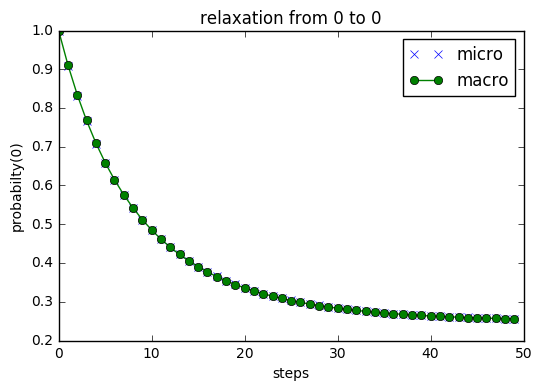

In [292]:
cg.cg_relaxation_from_state_to_state(0,0);

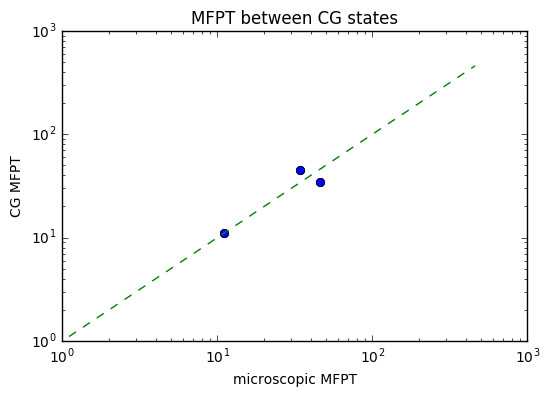

In [293]:
times=cg.compare_timescales()

### toy system 1

In [295]:
def trans_matrix(n,m):
    """
    defines a linear network with a given number of final states
    """
    t= np.zeros((n+m,n+m))

    for i,j in itertools.product(range(n),range(n)):
        if abs(i-j)==1:
            t[i,j]=10 # diffusional rate1
        
    for i,j in itertools.product(range(n,n+m),[n-1]):
        t[i,j]=2 #rate2
        t[j,i]=1 #rate3
    
    np.fill_diagonal(t,100.-t.sum(axis=1))
    tm = t/t.sum(axis=1)
    return tm

In [298]:
## define network and msm
n=4
m=3
tm = trans_matrix(n=n,m=m)
mm=msm.markov_model(tm)
#mm.stationary_distribution

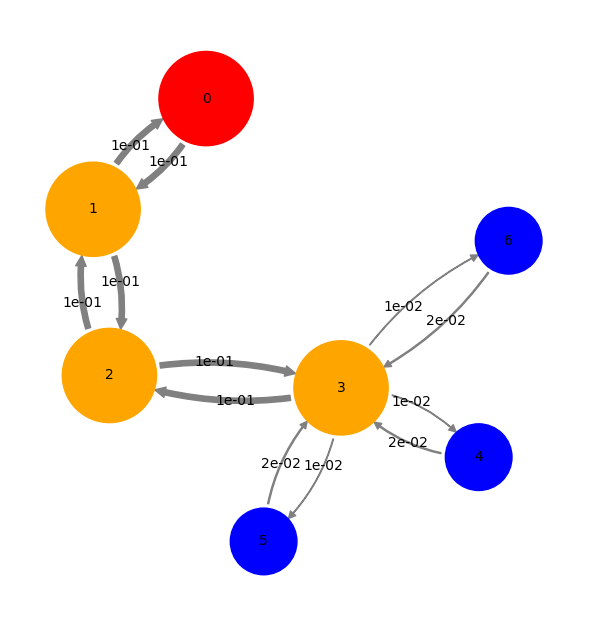

In [301]:
cols=['red']+(n-1)*['orange']+m*['blue']
dummy =mplt.plot_markov_model(mm,state_colors = cols,max_width=8, max_height=8)

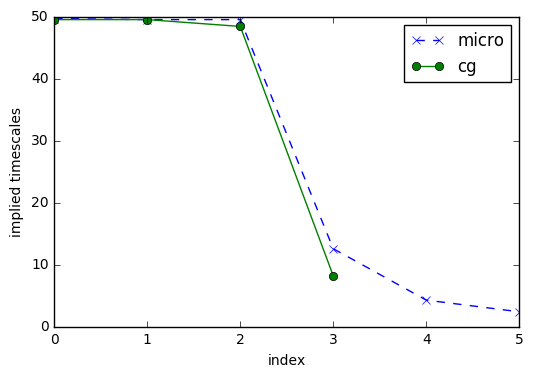

In [303]:
grp = [[0,1,2], [3] ,[4],[5],[6]]
cg = HummerCG(mm,grp)
cg.plot_timescales(10)

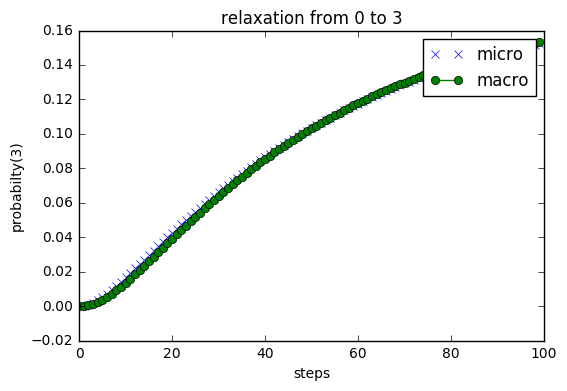

In [305]:
cg.cg_relaxation_from_state_to_state(0,3,100);

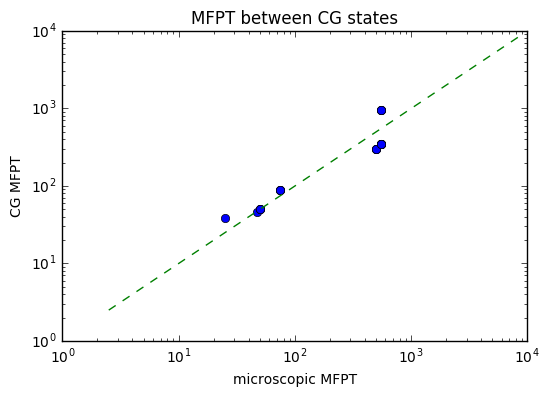

In [307]:
ts=cg.compare_timescales()

### toy model 2

In [309]:
nangle=9
ndist=3
angle =np.linspace(0,2*np.pi*(1-1./nangle),nangle)
da = angle[1]-angle[0]

dist = np.linspace(1,10,ndist)
dd = dist[1]-dist[0]
grid1 = itertools.product(list(angle),list(dist))
stat = [item for item in grid1]

nbound = 2
to_b= np.ceil(np.linspace(1e-4,1,len(angle))*(nbound))-1

M=np.zeros((len(stat)+nbound,len(stat)+nbound))

for i,oi in enumerate(stat):
    for j,oj in enumerate(stat):
        if i!=j:
            if (abs(oi[1]-oj[1])<1e-4) and \
            (abs(oi[0]-oj[0])-da<1e-4 or abs(oi[0]-oj[0]-2*np.pi)-da<1e-4): 
                #print(oi,oj)
                #and abs(oi[0]-oj[0])==2*pi/(5-1) and abs(oi[1]-oj[1])==10/(5-1):
                M[i,j]=5.
                M[j,i]=5.
                #print(oi,oj)
            if abs(oi[0]-oj[0])==0 and abs(oi[1]-oj[1])==dd:
                M[i,j]=5.
                M[j,i]=5.
                #print(oi,oj)

for i,oi in enumerate(stat):
    anindex = np.where(angle==oi[0])[0][0]
    offset = len(stat)
    if(oi[1]==dist[0]):
        #print(i,oi,offset+to_b[anindex] )
        M[i,offset+to_b[anindex]]=5.
        M[offset+to_b[anindex],i]=2.

    
np.fill_diagonal(M,3500.-M.sum(axis=1))
tm3 = M/M.sum(axis=1)
assert np.all(tm3.sum(axis=1)==1)

In [310]:
mm3=msm.markov_model(tm3)

In [311]:
## define nicer positions for plotting

outer = dist[-1]+3
pos = [[np.cos(s[0])*(outer-s[1]),np.sin(s[0])*(outer-s[1])] 
       for s in stat] + [
    [np.cos(angle[to_b==s].mean())*(outer+4),
     np.sin(angle[to_b==s].mean())*(outer+4)] 
    for s in range(nbound)]

In [312]:
## define cg groups
grps = [[28],[27],[12,15,18,21,24],[9,6,3,0]]
bulk = np.setdiff1d(range(28),np.concatenate(grps))
grps0 = grps + [list(bulk)]

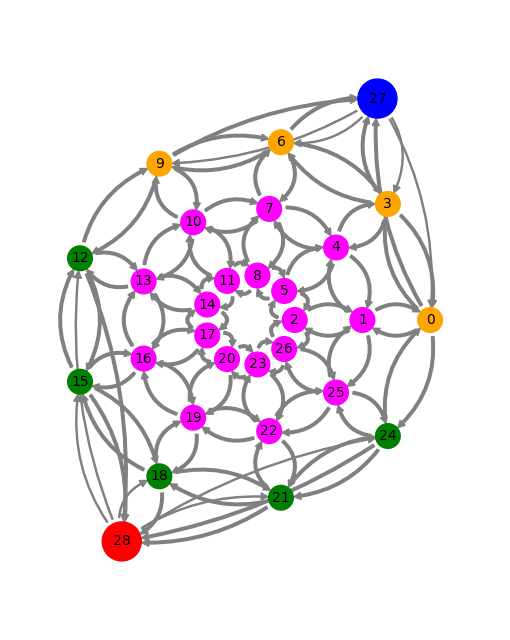

In [313]:
states_comm = np.empty(29)
for i,grp in enumerate(grps0):
    states_comm[np.array(grp)]=i
states_comm = states_comm.astype('int')
col1=np.array(['red','blue','green','orange','magenta','cyan'])[states_comm]

qq=mplt.plot_markov_model(mm3, pos = np.array(pos), state_colors=col1,
                      max_width=8, max_height=8,arrow_labels=None)

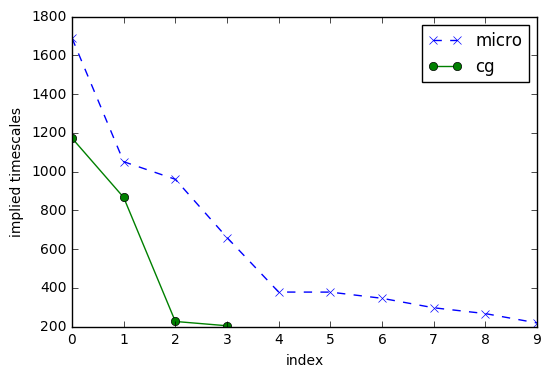

In [314]:
cg = HummerCG(mm3,grps0)
cg.plot_timescales(10)

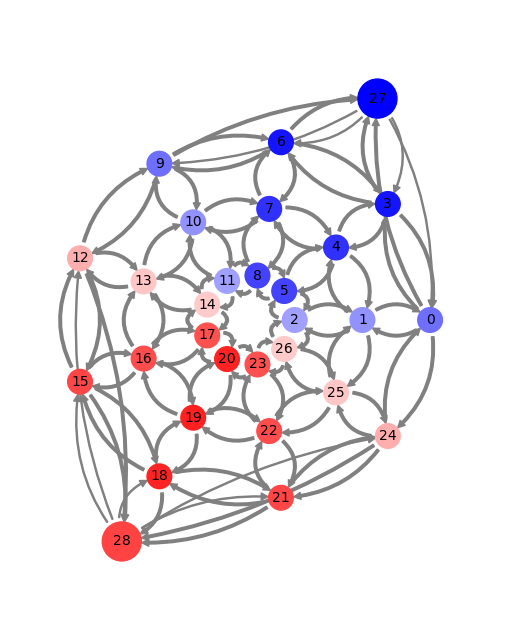

In [315]:
eigv = mm3.eigenvectors_right()[:,1]
cscale = 0.5+0.5*eigv/np.max(np.abs(eigv))
cols = [matplotlib.colors.rgb2hex(plt.cm.bwr(c)) for c in cscale]
qq=mplt.plot_markov_model(mm3, pos = np.array(pos), state_colors=cols,
                      max_width=8, max_height=8,arrow_labels=None)

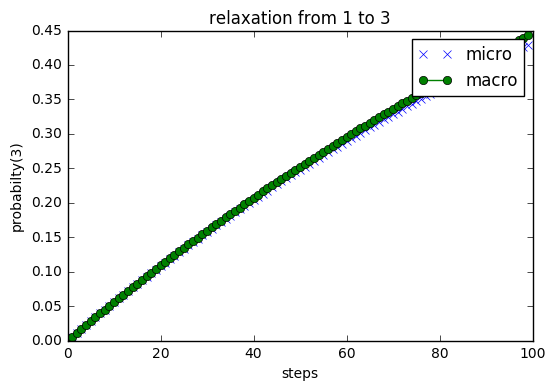

In [316]:
cg.cg_relaxation_from_state_to_state(1,3,100);

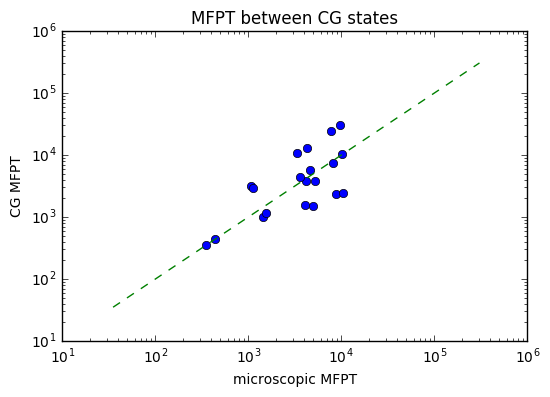

,from,to,MFPT micro,MFPT macro
0,0.0,1.0,8638.955051,2315.060569
1,0.0,2.0,4130.000000,3850.000000
2,0.0,3.0,8201.455051,7510.242277
3,0.0,4.0,7689.535578,24470.484554
4,1.0,0.0,10426.325061,2451.259459
5,1.0,2.0,10076.325061,10506.297293
6,1.0,3.0,5162.500000,3850.000000
7,1.0,4.0,9642.402812,30462.594585
8,2.0,0.0,350.000000,350.000000
9,2.0,1.0,4043.159985,1545.060569


In [317]:
cg.compare_timescales()